In [1]:
import pandas as pd

df = pd.read_csv('C:/Users/Rodrigo/OneDrive/Escritorio/UNAB/Clases_apuntes/Proyecto integradior ciencia de datos/proyecto1/dataset/train.csv')

print("Primeras filas del dataset:")
print(df.head())

print("\nInformación general del dataset:")
print(df.info())

print("\nEstadísticas descriptivas:")
print(df.describe())


Primeras filas del dataset:
  substation                 date  consumption
0    AJAHUEL  2018-01-01 00:00:00   137.330840
1    AJAHUEL  2018-01-01 01:00:00   124.045549
2    AJAHUEL  2018-01-01 02:00:00   118.137811
3    AJAHUEL  2018-01-01 03:00:00   107.899499
4    AJAHUEL  2018-01-01 04:00:00   100.362069

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244391 entries, 0 to 244390
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   substation   244391 non-null  object 
 1   date         244391 non-null  object 
 2   consumption  244391 non-null  float64
dtypes: float64(1), object(2)
memory usage: 5.6+ MB
None

Estadísticas descriptivas:
         consumption
count  244391.000000
mean      179.548024
std       156.018729
min      -199.000000
25%         0.181926
50%       172.099977
75%       262.179646
max       752.006309


In [2]:
import pandas as pd

print("Valores nulos en el dataset:")
print(df.isnull().sum())

df['date'] = pd.to_datetime(df['date'])

print("\nVerificando fechas faltantes por subestación...")

substations = df['substation'].unique()
missing_dates = {}

for sub in substations:
    
    sub_df = df[df['substation'] == sub]
    
    full_dates = pd.date_range(start=sub_df['date'].min(), end=sub_df['date'].max(), freq='H')
    
    missing = full_dates.difference(sub_df['date'])

    if not missing.empty:
        missing_dates[sub] = missing

if missing_dates:
    print("Fechas faltantes encontradas en las siguientes subestaciones:")
    for sub, dates in missing_dates.items():
        print(f"Subestación: {sub}, Fechas faltantes: {len(dates)}")
else:
    print("No se encontraron fechas faltantes en ninguna subestación.")


Valores nulos en el dataset:
substation     0
date           0
consumption    0
dtype: int64

Verificando fechas faltantes por subestación...
Fechas faltantes encontradas en las siguientes subestaciones:
Subestación: AJAHUEL, Fechas faltantes: 151
Subestación: BUIN, Fechas faltantes: 151
Subestación: CHENA, Fechas faltantes: 151
Subestación: CNAVIA, Fechas faltantes: 151
Subestación: ELSALTO, Fechas faltantes: 151
Subestación: FLORIDA, Fechas faltantes: 151
Subestación: LOSALME, Fechas faltantes: 151


In [3]:
completed_df = pd.DataFrame()

for sub in substations:
    sub_df = df[df['substation'] == sub]

    full_dates = pd.date_range(start=sub_df['date'].min(), end=sub_df['date'].max(), freq='H')
    full_df = pd.DataFrame({'date': full_dates})
    full_df['substation'] = sub

    merged_df = pd.merge(full_df, sub_df, on=['date', 'substation'], how='left')

    merged_df['consumption'] = merged_df['consumption'].interpolate(method='linear')

    completed_df = pd.concat([completed_df, merged_df])

completed_df = completed_df.sort_values(by=['substation', 'date']).reset_index(drop=True)

print("Valores nulos después de completar fechas e interpolar:")
print(completed_df.isnull().sum())
print("\nVerificando si las fechas están completas y continuas...")

final_missing_dates = {}

for sub in substations:
    sub_df = completed_df[completed_df['substation'] == sub]
    
    full_dates = pd.date_range(start=sub_df['date'].min(), end=sub_df['date'].max(), freq='H')

    missing = full_dates.difference(sub_df['date'])

    if not missing.empty:
        final_missing_dates[sub] = len(missing)

if not final_missing_dates:
    print("✅ Las fechas están completas y continuas para todas las subestaciones.")
else:
    print("❌ Aún existen fechas faltantes en las siguientes subestaciones:")
    for sub, count in final_missing_dates.items():
        print(f"Subestación: {sub}, Fechas faltantes: {count}")

print("\nPrimeras filas del DataFrame completo:")
print(completed_df.head())



Valores nulos después de completar fechas e interpolar:
date           0
substation     0
consumption    0
dtype: int64

Verificando si las fechas están completas y continuas...
✅ Las fechas están completas y continuas para todas las subestaciones.

Primeras filas del DataFrame completo:
                 date substation  consumption
0 2018-01-01 00:00:00    AJAHUEL   137.330840
1 2018-01-01 01:00:00    AJAHUEL   124.045549
2 2018-01-01 02:00:00    AJAHUEL   118.137811
3 2018-01-01 03:00:00    AJAHUEL   107.899499
4 2018-01-01 04:00:00    AJAHUEL   100.362069


Límite inferior: -392.92776375, Límite superior: 655.33618025

Cantidad de outliers encontrados: 156


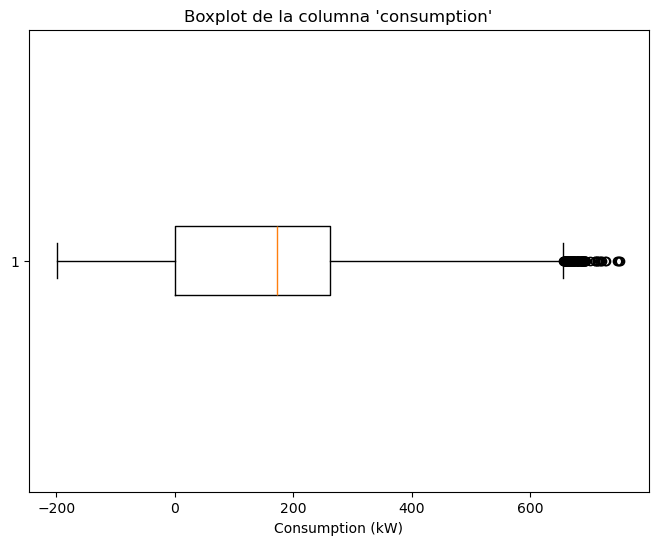


Ejemplos de outliers encontrados:
                      date substation  consumption
108359 2018-05-12 23:00:00     CNAVIA   752.006309
112623 2018-11-06 15:00:00     CNAVIA   658.311367
112624 2018-11-06 16:00:00     CNAVIA   659.263815
112647 2018-11-07 15:00:00     CNAVIA   667.335728
112648 2018-11-07 16:00:00     CNAVIA   674.023942


In [4]:
import matplotlib.pyplot as plt

Q1 = completed_df['consumption'].quantile(0.25)
Q3 = completed_df['consumption'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Límite inferior: {lower_bound}, Límite superior: {upper_bound}")

outliers = completed_df[(completed_df['consumption'] < lower_bound) | 
                        (completed_df['consumption'] > upper_bound)]

print(f"\nCantidad de outliers encontrados: {len(outliers)}")

plt.figure(figsize=(8, 6))
plt.boxplot(completed_df['consumption'], vert=False)
plt.title("Boxplot de la columna 'consumption'")
plt.xlabel("Consumption (kW)")
plt.show()

print("\nEjemplos de outliers encontrados:")
print(outliers.head())


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_20420\793189545.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df['hour'] = outliers_df['date'].dt.hour
C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_20420\793189545.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df['day'] = outliers_df['date'].dt.day
C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_20420\793189545.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

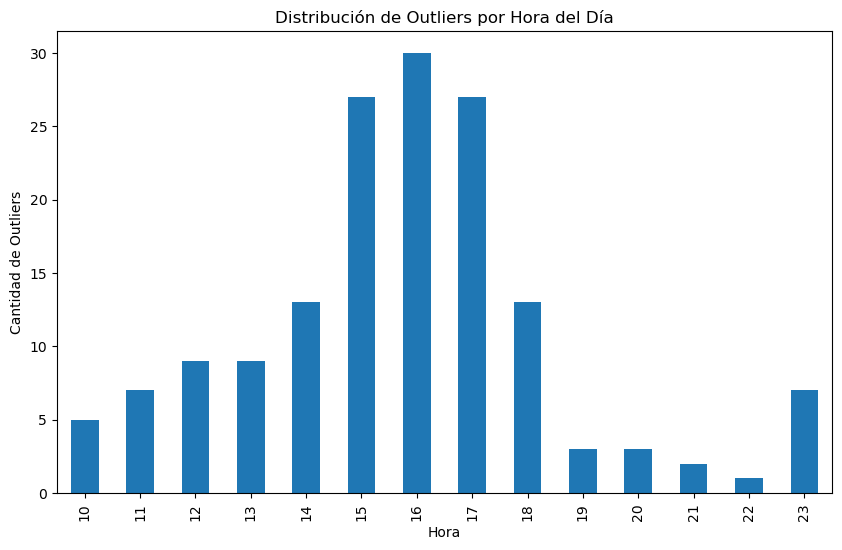

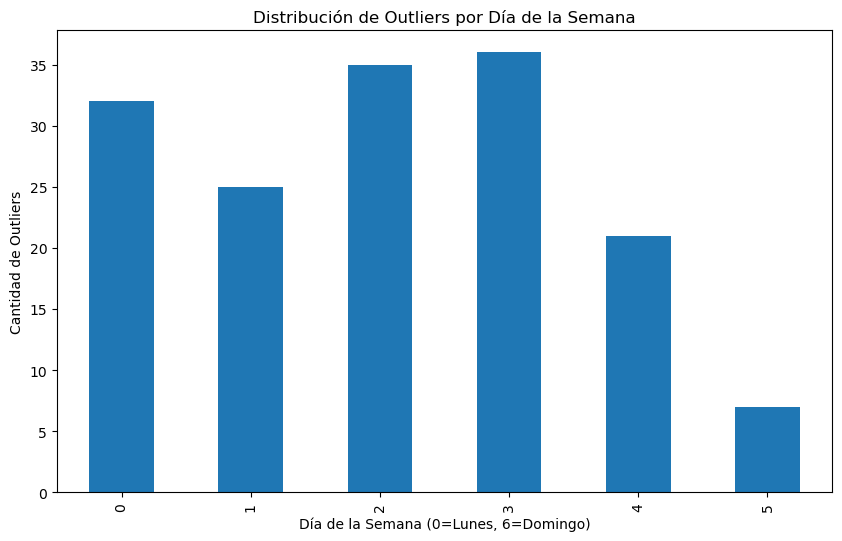

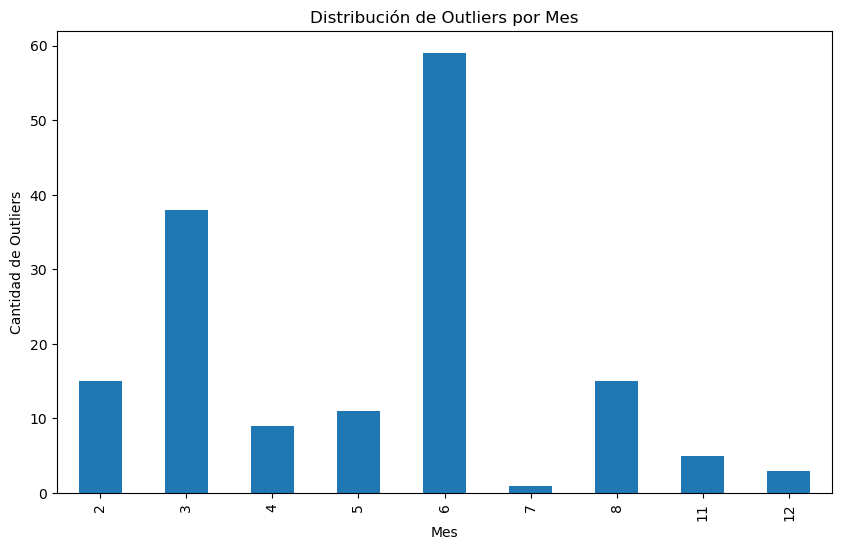

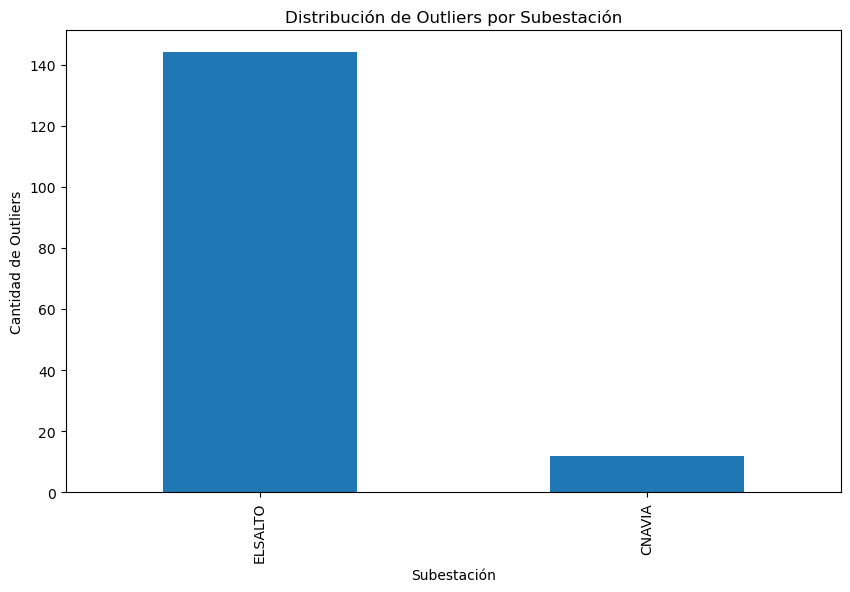

In [5]:
import matplotlib.pyplot as plt

outliers_df = completed_df[(completed_df['consumption'] > upper_bound)]

outliers_df['hour'] = outliers_df['date'].dt.hour
outliers_df['day'] = outliers_df['date'].dt.day
outliers_df['month'] = outliers_df['date'].dt.month
outliers_df['weekday'] = outliers_df['date'].dt.weekday

plt.figure(figsize=(10, 6))
outliers_df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Outliers por Hora del Día')
plt.xlabel('Hora')
plt.ylabel('Cantidad de Outliers')
plt.show()

# Distribución de outliers por día de la semana
plt.figure(figsize=(10, 6))
outliers_df['weekday'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Outliers por Día de la Semana')
plt.xlabel('Día de la Semana (0=Lunes, 6=Domingo)')
plt.ylabel('Cantidad de Outliers')
plt.show()

# Distribución de outliers por mes
plt.figure(figsize=(10, 6))
outliers_df['month'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Outliers por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Outliers')
plt.show()

# Distribución de outliers por subestación
plt.figure(figsize=(10, 6))
outliers_df['substation'].value_counts().plot(kind='bar')
plt.title('Distribución de Outliers por Subestación')
plt.xlabel('Subestación')
plt.ylabel('Cantidad de Outliers')
plt.show()


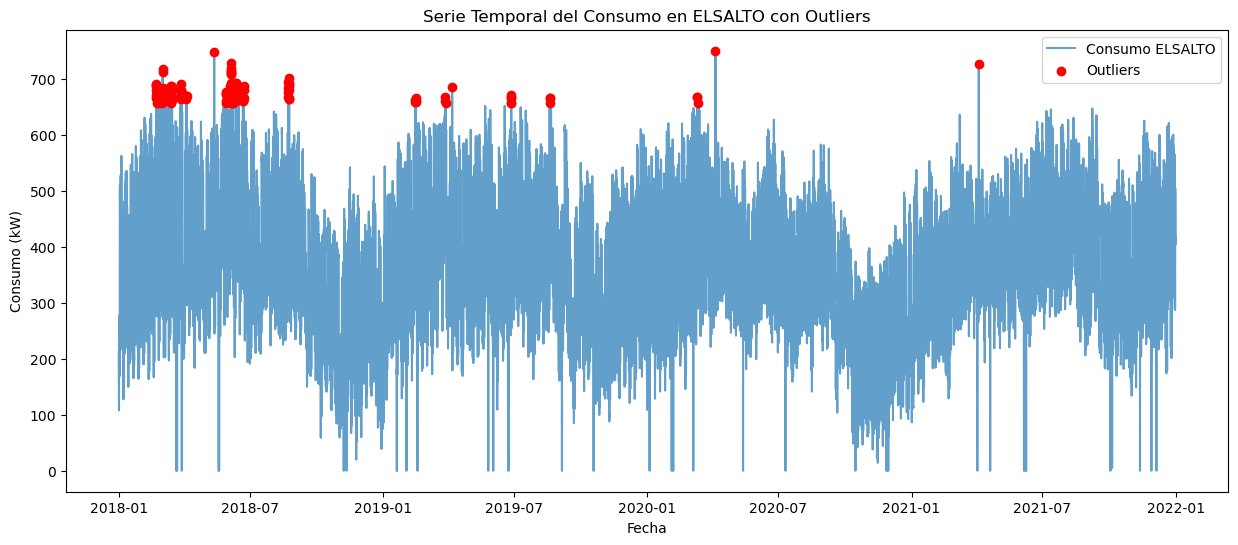

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_20420\2911317513.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elsalto_df['hour'] = elsalto_df['date'].dt.hour


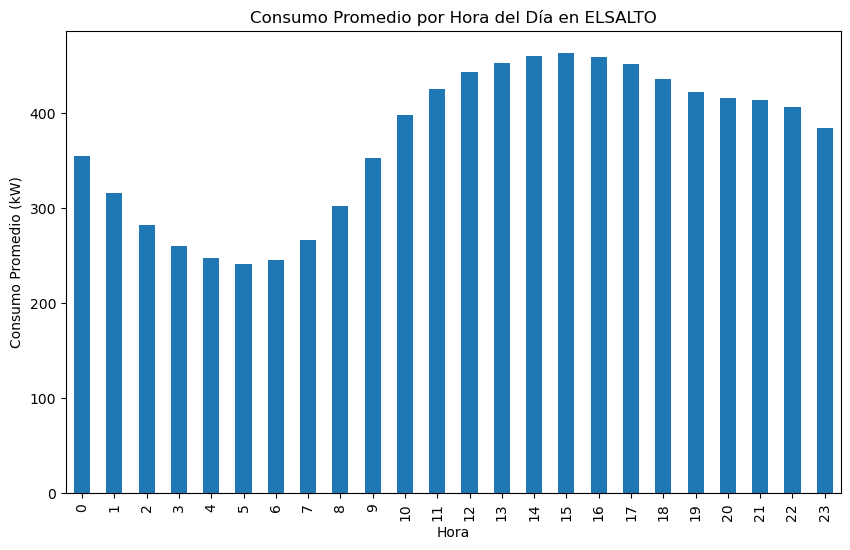

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_20420\2911317513.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elsalto_df['month'] = elsalto_df['date'].dt.month


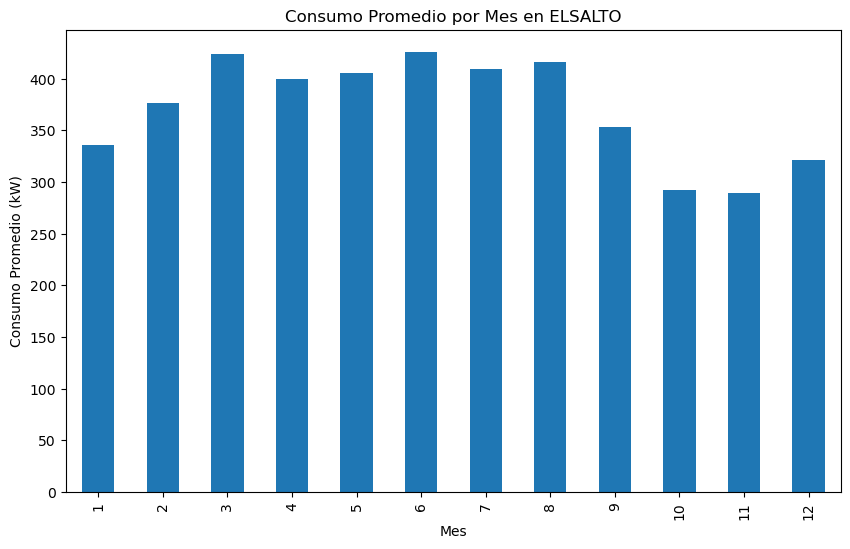

In [6]:
elsalto_df = completed_df[completed_df['substation'] == 'ELSALTO']

elsalto_outliers = elsalto_df[elsalto_df['consumption'] > upper_bound]

# Visualizar la serie temporal completa con outliers destacados
plt.figure(figsize=(15, 6))
plt.plot(elsalto_df['date'], elsalto_df['consumption'], label='Consumo ELSALTO', alpha=0.7)
plt.scatter(elsalto_outliers['date'], elsalto_outliers['consumption'], color='red', label='Outliers', zorder=5)
plt.title('Serie Temporal del Consumo en ELSALTO con Outliers')
plt.xlabel('Fecha')
plt.ylabel('Consumo (kW)')
plt.legend()
plt.show()

# Distribución horaria del consumo en ELSALTO
plt.figure(figsize=(10, 6))
elsalto_df['hour'] = elsalto_df['date'].dt.hour
elsalto_df.groupby('hour')['consumption'].mean().plot(kind='bar')
plt.title('Consumo Promedio por Hora del Día en ELSALTO')
plt.xlabel('Hora')
plt.ylabel('Consumo Promedio (kW)')
plt.show()

# Distribución mensual del consumo en ELSALTO
plt.figure(figsize=(10, 6))
elsalto_df['month'] = elsalto_df['date'].dt.month
elsalto_df.groupby('month')['consumption'].mean().plot(kind='bar')
plt.title('Consumo Promedio por Mes en ELSALTO')
plt.xlabel('Mes')
plt.ylabel('Consumo Promedio (kW)')
plt.show()


In [7]:
completed_df['year'] = completed_df['date'].dt.year
completed_df['month'] = completed_df['date'].dt.month
completed_df['day'] = completed_df['date'].dt.day
completed_df['hour'] = completed_df['date'].dt.hour
completed_df['weekday'] = completed_df['date'].dt.weekday

completed_df['is_weekend'] = completed_df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

def get_season(month):
    if month in [12, 1, 2]:
        return 'summer'
    elif month in [3, 4, 5]:
        return 'autumn'
    elif month in [6, 7, 8]:
        return 'winter'
    else:
        return 'spring'

completed_df['season'] = completed_df['month'].apply(get_season)

completed_df['time_index'] = range(1, len(completed_df) + 1)

print("Primeras filas con características adicionales:")
print(completed_df.head())
print("\nDistribución de estaciones del año:")
print(completed_df['season'].value_counts())


Primeras filas con características adicionales:
                 date substation  consumption  year  month  day  hour  \
0 2018-01-01 00:00:00    AJAHUEL   137.330840  2018      1    1     0   
1 2018-01-01 01:00:00    AJAHUEL   124.045549  2018      1    1     1   
2 2018-01-01 02:00:00    AJAHUEL   118.137811  2018      1    1     2   
3 2018-01-01 03:00:00    AJAHUEL   107.899499  2018      1    1     3   
4 2018-01-01 04:00:00    AJAHUEL   100.362069  2018      1    1     4   

   weekday  is_weekend  season  time_index  
0        0           0  summer           1  
1        0           0  summer           2  
2        0           0  summer           3  
3        0           0  summer           4  
4        0           0  summer           5  

Distribución de estaciones del año:
season
autumn    61824
winter    61824
spring    61152
summer    60648
Name: count, dtype: int64


In [8]:
duplicated_rows = completed_df[completed_df.duplicated()]
num_duplicates = len(duplicated_rows)

print(f"Cantidad de registros duplicados encontrados: {num_duplicates}")

if num_duplicates > 0:
    print("\nEjemplos de registros duplicados:")
    print(duplicated_rows.head())
else:
    print("No se encontraron registros duplicados.")

completed_df = completed_df.drop_duplicates()
print("\nCantidad de registros después de eliminar duplicados:", len(completed_df))


Cantidad de registros duplicados encontrados: 0
No se encontraron registros duplicados.

Cantidad de registros después de eliminar duplicados: 245448


In [9]:
test_file_path = 'C:/Users/Rodrigo/OneDrive/Escritorio/UNAB/Clases_apuntes/Proyecto integradior ciencia de datos/proyecto1/dataset/test.csv'
test_df = pd.read_csv(test_file_path)

test_df['date'] = pd.to_datetime(test_df['date'])

test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['hour'] = test_df['date'].dt.hour
test_df['weekday'] = test_df['date'].dt.weekday
test_df['is_weekend'] = test_df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
test_df['season'] = test_df['month'].apply(get_season)
test_df['time_index'] = range(1, len(test_df) + 1)

test_df[numeric_columns] = scaler.transform(test_df[numeric_columns])

print("Primeras filas del dataset de prueba transformado:")
print(test_df.head())

NameError: name 'scaler' is not defined